In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import math
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Nice inline figures
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False


Device: cuda


In [3]:
def exists(x):
    return x is not None

# Creates unique "fingerprints" for each timestep (0-999) using sine and cosine waves. This helps the model know which denoising step it's currently performing.
def sinusoidal_time_embedding(timesteps, dim: int):
    """
    Standard sinusoidal embedding for integer timesteps.
    timesteps: (B,) long tensor
    returns: (B, dim)
    """
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device) / max(half - 1, 1))
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)  # (B, half)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1) # (B, 2*half)
    if dim % 2 == 1:  # pad if odd
        emb = F.pad(emb, (0,1))
    return emb
    
# Visualization helper that displays multiple images in a neat grid format, converting from the model's internal format [-1,1] to displayable format [0,1].
def show_grid(tensor, nrow=10, title=None):
    """
    tensor: (N, C, H, W) in [-1,1]; displays as a grid inline.
    """
    tensor = (tensor.clamp(-1, 1) + 1) / 2.0  # to [0,1]
    grid = make_grid(tensor, nrow=nrow)
    img = grid.permute(1,2,0).detach().cpu().numpy()
    plt.figure()
    if title: plt.title(title)
    plt.imshow(img, cmap="gray" if tensor.size(1) == 1 else None)
    plt.axis('off')
    plt.show()


In [4]:
@dataclass
# Stores the hyperparameters like how many timesteps (1000) and how aggressively to add noise.
class DiffusionConfig:
    timesteps: int = 1000
    beta_start: float = 1e-4
    beta_end: float = 2e-2
    schedule: str = "cosine"  # "linear" or "cosine"

# The brain of the diffusion process. It:
# Calculates noise schedules (how much noise to add at each step)
# Implements q_sample() to add noise to clean images
# Uses either linear or cosine noise scheduling (cosine is more advanced)
# Precomputes mathematical constants needed for the diffusion process
class DiffusionScheduler:
    def __init__(self, cfg: DiffusionConfig, device):
        self.cfg = cfg
        self.device = device
        self._setup_betas()

    def _cosine_beta_schedule(self, timesteps, s=0.008):
        # Improved DDPM (Nichol & Dhariwal, 2021)
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return betas.clamp(max=0.999)

    def _linear_beta_schedule(self, timesteps, beta_start, beta_end):
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

    def _setup_betas(self):
        T = self.cfg.timesteps
        if self.cfg.schedule == "cosine":
            betas = self._cosine_beta_schedule(T)
        else:
            betas = self._linear_beta_schedule(T, self.cfg.beta_start, self.cfg.beta_end)

        self.betas = betas.to(self.device).float()
        self.alphas = (1. - self.betas)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1,0), value=1.0)

        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1. / self.alphas)

        # posterior variance for q(x_{t-1}|x_t, x0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_hat = self.sqrt_alphas_cumprod[t].view(-1,1,1,1)
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise

    def predict_x0(self, x_t, t, eps_pred):
        sqrt_recip_alpha_hat = (1. / self.sqrt_alphas_cumprod[t]).view(-1,1,1,1)
        sqrt_recip_m1_alpha_hat = (1. / self.sqrt_alphas_cumprod[t] - 1).view(-1,1,1,1)
        return sqrt_recip_alpha_hat * x_t - sqrt_recip_m1_alpha_hat * eps_pred


In [5]:
# Neural Network Architecture

# ResBlock: A building block that processes images while incorporating:
# 1.Time information (what denoising step we're on)
# 2.Optional class information (what digit we want to generate)
# 3.Skip connections for better gradient flow
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, class_dim=None, dropout=0.0):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.class_proj = nn.Linear(class_dim, out_ch) if class_dim is not None else None

        self.block1 = nn.Sequential(
            nn.GroupNorm(8, in_ch), nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_ch), nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, padding=1)
        )
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb=None):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        if self.class_proj is not None and c_emb is not None:
            h = h + self.class_proj(c_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.block2(h)
        return h + self.skip(x)

# Downsampling block that reduces image size while increasing feature depth. Like zooming out to see broader patterns.
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, class_dim=None):
        super().__init__()
        self.res1 = ResBlock(in_ch, out_ch, time_dim, class_dim)
        self.res2 = ResBlock(out_ch, out_ch, time_dim, class_dim)
        self.pool = nn.Conv2d(out_ch, out_ch, 3, stride=2, padding=1)

    def forward(self, x, t_emb, c_emb=None):
        x = self.res1(x, t_emb, c_emb)
        x = self.res2(x, t_emb, c_emb)
        skip = x
        x = self.pool(x)
        return x, skip

# Upsampling block that increases image size back to original dimensions. Like zooming back in to add fine details.
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, skip_ch, time_dim, class_dim=None):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        self.res1 = ResBlock(out_ch + skip_ch, out_ch, time_dim, class_dim)
        self.res2 = ResBlock(out_ch, out_ch, time_dim, class_dim)

    def forward(self, x, skip, t_emb, c_emb=None):
        x = self.up(x)
        if x.shape[-1] != skip.shape[-1] or x.shape[-2] != skip.shape[-2]:
            x = F.pad(x, (0, skip.shape[-1] - x.shape[-1], 0, skip.shape[-2] - x.shape[-2]))
        x = torch.cat([x, skip], dim=1)
        x = self.res1(x, t_emb, c_emb)
        x = self.res2(x, t_emb, c_emb)
        return x

# UNet: The main neural network with an hourglass shape:
# 1.Encoder (Down blocks): Compresses 28×28 image → smaller feature maps
# 2.Bottleneck (Mid blocks): Processes the compressed representation
# 3.Decoder (Up blocks): Expands back to 28×28 output
# 4.Skip connections connect encoder to decoder for preserving details
class UNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_dim=128, class_cond=True, num_classes=10, dropout=0.0):
        super().__init__()
        self.class_cond = class_cond
        class_dim = 0
        if class_cond:
            self.label_emb = nn.Embedding(num_classes + 1, time_dim)  # +1 for null
            class_dim = time_dim

        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim*4),
            nn.SiLU(),
            nn.Linear(time_dim*4, time_dim)
        )

        self.init = nn.Conv2d(in_ch, base_ch, 3, padding=1)

        self.down1 = Down(base_ch,      base_ch,      time_dim, class_dim or None)
        self.down2 = Down(base_ch,      base_ch*2,    time_dim, class_dim or None)
        self.down3 = Down(base_ch*2,    base_ch*4,    time_dim, class_dim or None)

        self.mid1 = ResBlock(base_ch*4, base_ch*4, time_dim, class_dim or None, dropout=dropout)
        self.mid2 = ResBlock(base_ch*4, base_ch*4, time_dim, class_dim or None, dropout=dropout)

        self.up1  = Up(base_ch*4, base_ch*2, skip_ch=base_ch*4, time_dim=time_dim, class_dim=class_dim or None)
        self.up2  = Up(base_ch*2, base_ch,   skip_ch=base_ch*2, time_dim=time_dim, class_dim=class_dim or None)
        self.up3  = Up(base_ch,   base_ch,   skip_ch=base_ch,   time_dim=time_dim, class_dim=class_dim or None)

        self.out = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, 3, padding=1)
        )

    def forward(self, x, t, y: Optional[torch.Tensor] = None, drop_label_prob: float = 0.0):
        if self.class_cond:
            if self.training and drop_label_prob > 0.0:
                mask = (torch.rand_like(y.float()) < drop_label_prob)
                y = y.clone()
                y[mask] = 10  # null
            c_emb = self.label_emb(y)
        else:
            c_emb = None

        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        x = self.init(x)
        x, s1 = self.down1(x, t_emb, c_emb)
        x, s2 = self.down2(x, t_emb, c_emb)
        x, s3 = self.down3(x, t_emb, c_emb)

        x = self.mid1(x, t_emb, c_emb)
        x = self.mid2(x, t_emb, c_emb)

        x = self.up1(x, s3, t_emb, c_emb)
        x = self.up2(x, s2, t_emb, c_emb)
        x = self.up3(x, s1, t_emb, c_emb)
        return self.out(x)


In [6]:
# Training Components

# ddpm_loss(): The training objective that:
# Picks a random timestep for each image
# Adds the corresponding amount of noise
# Asks the model to predict the noise
# Measures how close the prediction is to actual noise
def ddpm_loss(model, scheduler, x0, y, label_drop_prob=0.1):
    B = x0.size(0)
    t = torch.randint(0, scheduler.cfg.timesteps, (B,), device=x0.device, dtype=torch.long)
    noise = torch.randn_like(x0)
    x_t = scheduler.q_sample(x0, t, noise=noise)
    eps_pred = model(x_t, t, y if model.class_cond else None, drop_label_prob=label_drop_prob)
    return F.mse_loss(eps_pred, noise)

def get_dataloaders(data_dir="./data", batch_size=128):
    tfm = transforms.Compose([
        transforms.ToTensor(),                 # [0,1]
        transforms.Lambda(lambda x: x*2 - 1), # [-1,1]
    ])
    train = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=tfm)
    test  = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=tfm)
    return (
        DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True),
        DataLoader(test,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True),
    )


## Sampling (Generation) Functions

In [7]:
# p_sample(): Single reverse denoising step that:
# Takes a noisy image and predicts the noise
# Removes predicted noise to get a slightly cleaner image
# Adds controlled randomness (except at the final step)
@torch.no_grad()
def p_sample(model, scheduler, x_t, t, y=None, cfg_scale=0.0):
    """
    One reverse step with optional classifier-free guidance.
    t is (B,) long; all entries equal for this step.
    """
    # Default to null label for unconditional if model is class-conditional
    if getattr(model, "class_cond", False) and y is None:
        y = torch.full((x_t.size(0),), 10, device=x_t.device, dtype=torch.long)

    betas = scheduler.betas
    sqrt_recip_alpha = scheduler.sqrt_recip_alphas[t].view(-1,1,1,1)
    coef = betas[t].view(-1,1,1,1) / torch.sqrt(1 - scheduler.alphas_cumprod[t]).view(-1,1,1,1)

    if model.class_cond and cfg_scale > 0.0:
        y_null = torch.full_like(y, 10)  # null label for CFG
        eps_cond = model(x_t, t, y, drop_label_prob=0.0)
        eps_uncond = model(x_t, t, y_null, drop_label_prob=0.0)
        eps = eps_uncond + cfg_scale * (eps_cond - eps_uncond)
    else:
        eps = model(x_t, t, y if model.class_cond else None, drop_label_prob=0.0)

    mean = sqrt_recip_alpha * (x_t - coef * eps)

    if (t == 0).all():
        return mean
    else:
        noise = torch.randn_like(x_t)
        var = scheduler.posterior_variance[t].view(-1,1,1,1)
        return mean + torch.sqrt(var) * noise


# sample_loop(): Runs the full generation process:
# Starts with pure random noise
# Applies p_sample() 1000 times
# Each step removes a bit more noise
# Results in a clean, realistic digit

@torch.no_grad()
def sample_loop(model, scheduler, shape, y=None, cfg_scale=0.0, desc="Sampling"):
    x_t = torch.randn(shape, device=device)
    T = scheduler.cfg.timesteps
    for i in tqdm(reversed(range(T)), total=T, desc=desc, leave=False):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        x_t = p_sample(model, scheduler, x_t, t, y=y, cfg_scale=cfg_scale)
    return x_t


## Visualization Functions

In [8]:
# Creates a 10×10 grid showing 10 samples of each digit (0-9) to visualize training progress.
@torch.no_grad()
def show_epoch_grid_0_to_9(model, scheduler, cfg_scale=2.0, title="Epoch grid: classes 0..9"):
    """
    Generates 100 samples: digits 0..9 (10 each), shown as a 10x10 grid.
    """
    model.eval()
    n = 100
    classes = torch.arange(0, 10, device=device).repeat_interleave(10)  # 0..9, each 10 times
    imgs = sample_loop(model, scheduler, (n, 1, 28, 28), y=classes, cfg_scale=cfg_scale, desc="Sampling (epoch grid)")
    show_grid(imgs, nrow=10, title=title)

# Shows the step-by-step denoising process of a real MNIST image, like a time-lapse of noise removal.
@torch.no_grad()
def show_denoise_panel(model, scheduler, data_dir="./data", sample_index=0, start_t=750, frames=8):
    """
    Shows step-by-step denoising of one real MNIST test image from timestep start_t down to 0.
    Captures 'frames' evenly spaced snapshots (including the final denoised image).
    """
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x*2 - 1),
    ])
    test = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=tfm)
    x0, label = test[sample_index % len(test)]  # x0 in [-1,1], shape (1,28,28)
    x0 = x0.unsqueeze(0).to(device)

    # corrupt to x_{start_t}
    noise = torch.randn_like(x0)
    x_t = scheduler.q_sample(x0, torch.tensor([start_t], device=device, dtype=torch.long), noise=noise)

    # which timesteps to capture (inclusive of end)
    capture_ts = torch.linspace(start_t, 0, steps=frames, dtype=torch.long, device=device)
    capture_set = set(int(t.item()) for t in capture_ts)

    panels = []
    for i in tqdm(reversed(range(start_t + 1)), total=start_t + 1, desc="Denoising panel"):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        x_t = p_sample(model, scheduler, x_t, t, y=None, cfg_scale=0.0)  # unconditional reverse
        if i in capture_set:
            panels.append(x_t.clone())

    # Stack captured frames into a row
    panel = torch.cat(panels, dim=0)  # (frames, 1, 28, 28)
    show_grid(panel, nrow=frames, title=f"Denoising steps (label={label}, start_t={start_t})")


# Generate multiple or single samples of a specific digit.
@torch.no_grad()
def generate_digit_grid(model, scheduler, digit: int, num_samples: int = 100, cfg_scale: float = 2.0, nrow: int = 10, title: str = None):
    """
    Display a grid of a single digit (0..9) sampled from noise.
    """
    model.eval()
    y = torch.full((num_samples,), int(digit), device=device, dtype=torch.long)
    imgs = sample_loop(model, scheduler, (num_samples, 1, 28, 28), y=y, cfg_scale=cfg_scale, desc=f"Sampling (digit={digit})")
    show_grid(imgs, nrow=nrow, title=title or f"Digit {digit} (CFG={cfg_scale})")

@torch.no_grad()
def generate_single_digit(model, scheduler, digit: int, cfg_scale: float = 2.0, title: str = None):
    """
    Display a single sample of a chosen digit (0..9) — useful if you just want one image.
    """
    model.eval()
    y = torch.full((1,), int(digit), device=device, dtype=torch.long)
    img = sample_loop(model, scheduler, (1, 1, 28, 28), y=y, cfg_scale=cfg_scale, desc=f"Sampling one (digit={digit})")
    show_grid(img, nrow=1, title=title or f"Single digit {digit} (CFG={cfg_scale})")



## Main Training Function

In [9]:
# train_ddpm(): Orchestrates the entire training process:

# Loads MNIST data (handwritten digits 0-9)
# Creates the model and scheduler
# For each epoch:
    # Trains on all data batches
    # Shows progress with generated samples
    # Displays denoising visualization

def train_ddpm(
    epochs=5,
    batch_size=128,
    lr=2e-4,
    schedule="cosine",
    timesteps=1000,
    base_ch=64,
    time_dim=128,
    label_drop_prob=0.1,
    class_cond=True,
    cfg_scale_for_grid=2.0,
    data_dir="./data"
):
    print("Starting training...")
    train_loader, _ = get_dataloaders(data_dir=data_dir, batch_size=batch_size)

    sched_cfg = DiffusionConfig(timesteps=timesteps, schedule=schedule)
    scheduler = DiffusionScheduler(sched_cfg, device)

    model = UNet(
        in_ch=1, base_ch=base_ch, time_dim=time_dim,
        class_cond=class_cond, num_classes=10, dropout=0.0
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    for epoch in range(1, epochs + 1):
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = ddpm_loss(model, scheduler, x, y, label_drop_prob=label_drop_prob)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        # ---- After-epoch displays (inline) ----
        model.eval()
        with torch.no_grad():
            # 1) 0..9 class grid (10x10)
            show_epoch_grid_0_to_9(model, scheduler, cfg_scale=cfg_scale_for_grid, title=f"Epoch {epoch:02d} — classes 0..9 (CFG={cfg_scale_for_grid})")
            # 2) Denoising step-by-step panel for one test image
            show_denoise_panel(model, scheduler, data_dir=data_dir, sample_index=0, start_t=750, frames=8)

    print("Training finished.")
    return model, scheduler


Starting training...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 466kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]
Epoch 1/5: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s, loss=0.0569]


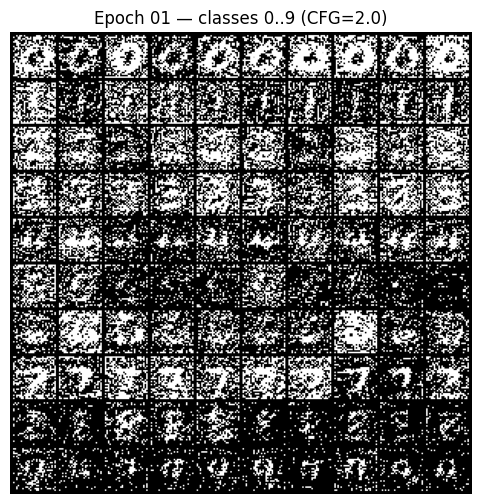

Denoising panel: 100%|██████████| 751/751 [00:06<00:00, 112.99it/s]


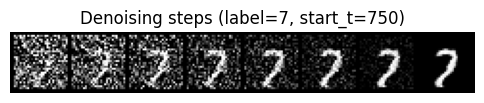

Epoch 2/5: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s, loss=0.0503]


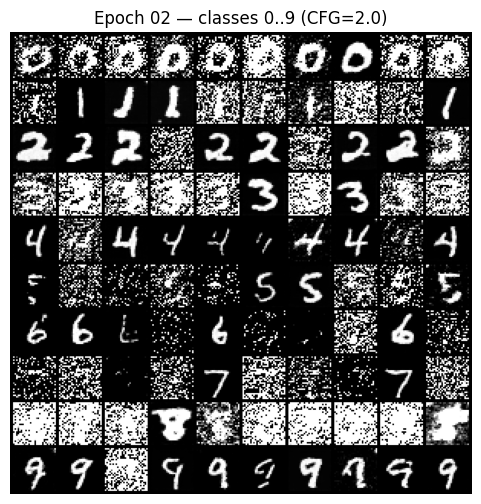

Denoising panel: 100%|██████████| 751/751 [00:06<00:00, 115.58it/s]


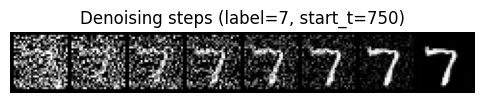

Epoch 3/5: 100%|██████████| 469/469 [00:44<00:00, 10.57it/s, loss=0.0413]


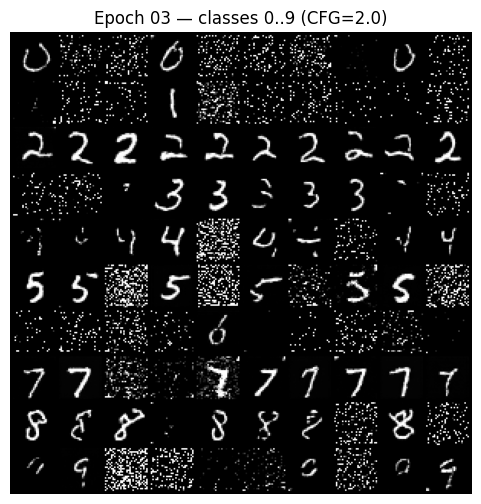

Denoising panel: 100%|██████████| 751/751 [00:06<00:00, 115.14it/s]


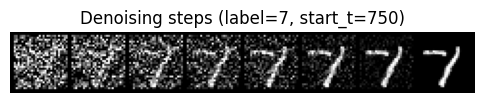

Epoch 4/5: 100%|██████████| 469/469 [00:44<00:00, 10.58it/s, loss=0.0421]


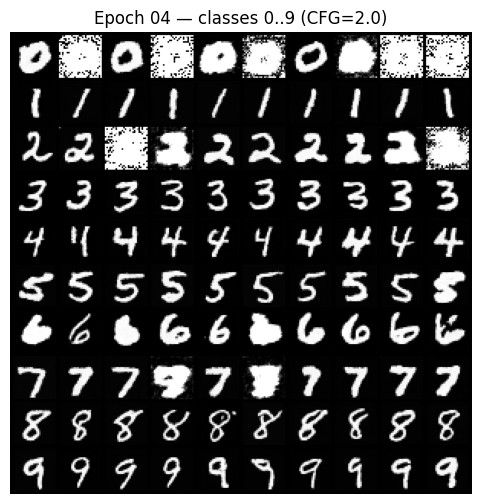

Denoising panel: 100%|██████████| 751/751 [00:06<00:00, 115.78it/s]


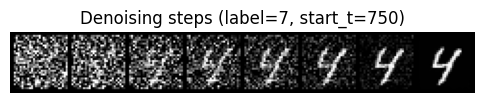

Epoch 5/5: 100%|██████████| 469/469 [00:44<00:00, 10.64it/s, loss=0.0379]


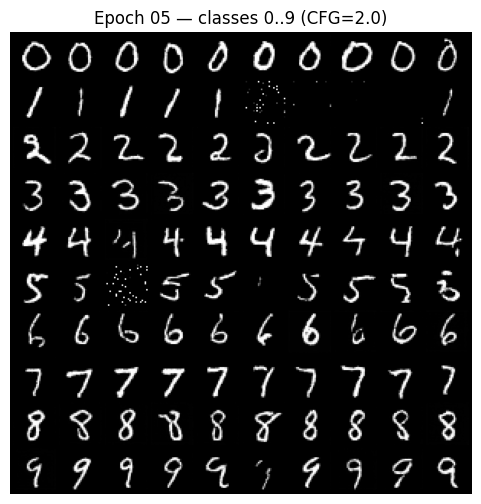

Denoising panel: 100%|██████████| 751/751 [00:06<00:00, 116.45it/s]


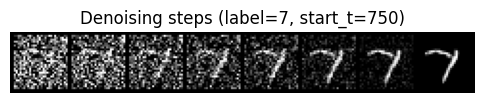

Training finished.


In [10]:
model, scheduler = train_ddpm(
    epochs=5,            # you can try 2–3 for a quick demo or 8–10 for cleaner digits
    batch_size=128,
    lr=2e-4,             # original LR that converged quickly
    schedule="cosine",
    timesteps=1000,
    base_ch=64,
    time_dim=128,
    label_drop_prob=0.1,
    class_cond=True,
    cfg_scale_for_grid=2.0,   # try 1.0–2.0 early; 2.0 is the original
    data_dir="./data"
)


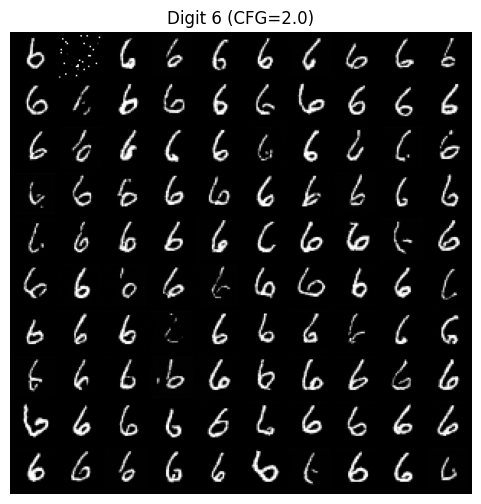

In [14]:
# Show a 10x10 grid of digit 7
generate_digit_grid(model, scheduler, digit=6, num_samples=100, cfg_scale=2.0, nrow=10)




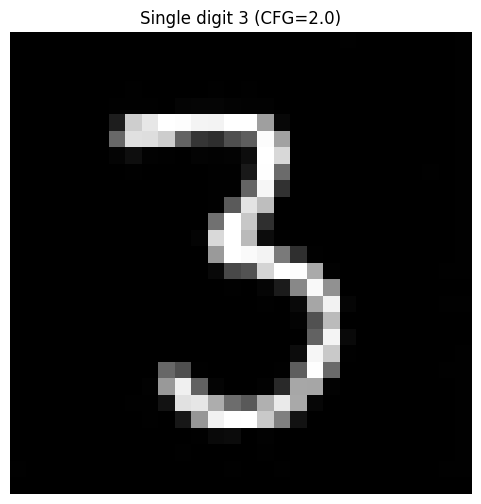

In [13]:
# Show a single sample of digit 3
generate_single_digit(model, scheduler, digit=3, cfg_scale=2.0)